In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cudf
from cuml.tsa.holtwinters import ExponentialSmoothing as cuES
from statsmodels.tsa.holtwinters import ExponentialSmoothing as smES
from sklearn.metrics import r2_score

In [118]:
def trend(x, m=1, b=0):
    return m*x + b

def sine_season(x, fs=100, f=2, amp=1):
    return amp * np.sin(2*np.pi*f * (x/fs))

def normal_noise(scale=1, size=1):
    return np.random.normal(scale=scale, size=size) 

In [119]:
def get_timeseries_components(fs=100, f=4, m=1, b=0, amp=1, scale=1):
    x = np.arange(fs)
    t = trend(x, m, b)
    s = sine_season(x, fs, f, amp)
    n = normal_noise(scale, fs)
    return (t, s, n)

In [120]:
t, s, n = get_timeseries_components(100, 4, 1, 0, 20, 2.5)
a = t + s + n
split = 75
train_a = a[:split]
test_a = a[split:]

/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


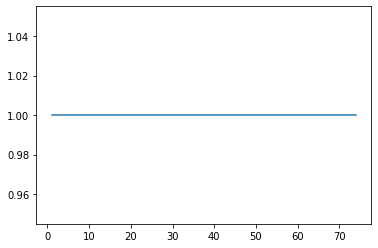

In [121]:
plt.plot(t[:split]/np.arange(75))

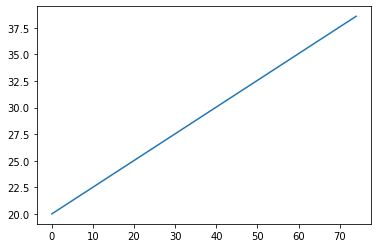

In [122]:
plt.plot(20 + 2*np.pi*4 * (np.arange(75)/100))

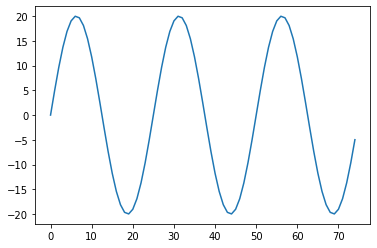

In [123]:
plt.plot(s[:split])

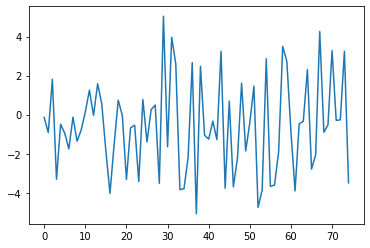

In [124]:
plt.plot(n[:split])

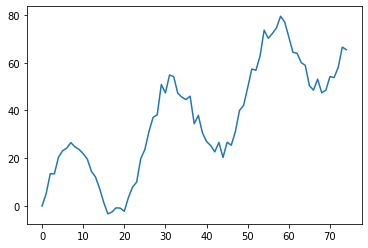

In [125]:
plt.plot(train_a)

In [126]:
%%time

cu = cuES(train_a, seasonal_periods=25, start_periods=2, ts_num=1, eps=2.24e-7, seasonal='add')
cu = cu.fit()

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 19.3 ms


In [127]:
%%time

sm = smES(train_a, seasonal_periods=25, seasonal='add')
sm = sm.fit()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.1 ms


/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Text(0.5, 1.0, 'cuml vs statsmodels predictions on sine waves')

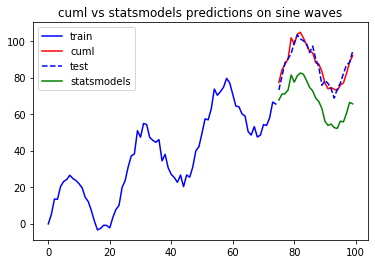

In [128]:
cu_f = cu.forecast(25)
sm_f = sm.forecast(25)
plt.plot(np.arange(0, split), train_a, color='b')
plt.plot(np.arange(split, 100), cu_f.to_pandas(), color='r')
plt.plot(np.arange(split, 100), test_a, color='b', linestyle='dashed')
plt.plot(np.arange(split, 100), sm_f, color='g')
plt.legend(['train', 'cuml', 'test', 'statsmodels'])
plt.title("cuml vs statsmodels predictions on sine waves")

In [129]:
r2_score(test_a, cu_f), r2_score(test_a, sm_f)

(0.8855977701116076, -3.000514807671194)

In [132]:
# fs_b = [100, 1000, 10_000, 100_000, 1_000_000]
# s_b = [25, 250, 2_500, 25_000, 250_000]
from time import time

fs_b = [100, 1000, 10_000]
s_b = [20, 200, 2000]

cu_scores = []
sm_scores = []
cu_times = []
sm_times = []
for i in range(len(fs_b)):
    split = int(fs_b[i] * 0.8)
    t, s, n = get_timeseries_components(fs_b[i], fs_b[i] / s_b[i], 1, 0, 20, 5)
    data = t + s + n
    train, test = data[:split], data[split:]
    
    st = time()
    cu = cuES(train, seasonal_periods=s_b[i], start_periods=2, ts_num=1, eps=2.24e-7, seasonal='additive')
    cu = cu.fit()
    et = time()
    cu_times.append(et - st)
    
    st = time()
    sm = smES(train, seasonal_periods=s_b[i], seasonal='additive')
    sm = sm.fit()
    et = time()
    sm_times.append(et - st)
    
    cu_f = cu.forecast(fs_b[i] - split)
    sm_f = sm.forecast(fs_b[i] - split)
    cu_scores.append(r2_score(cu_f, test))
    sm_scores.append(r2_score(sm_f, test))

/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [133]:
cu_scores, sm_scores, cu_times, sm_times

([0.7197105323278371, 0.979651347998714, 0.9998513617433814],
 [-0.0826110551298409, -10.982415456452205, -6.520724653768054],
 [0.0249173641204834, 0.18935441970825195, 2.5914621353149414],
 [0.01027536392211914, 0.11754417419433594, 0.8448343276977539])

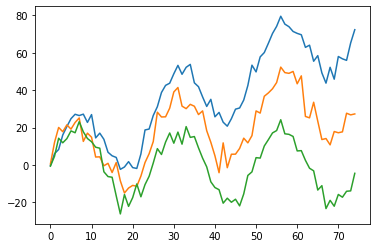

In [146]:
ta, sa, na = get_timeseries_components(m=1, amp=20, scale=2.5)
tb, sb, nb = get_timeseries_components(m=0.5, amp=20, scale=5)
tc, sc, nc = get_timeseries_components(m=0, amp=20, scale=3.3)
a = ta + sa + na
b = tb + sb + nb
c = tc + sc + nc
split = 75
train_a, train_b, train_c = a[:split], b[:split], c[:split]
test_a, test_b, test_c = a[split:], b[split:], c[split:]
train_df = cudf.DataFrame({"a":train_a, "b":train_b, "c":train_c})
test_df = cudf.DataFrame({"a":test_a, "b":test_b, "c":test_c})
plt.plot(train_df.to_pandas())

In [147]:
cu = cuES(train_df, seasonal_periods=25, start_periods=3, ts_num=3, eps=2.24e-7, seasonal='additive')
cu = cu.fit()

Text(0.5, 1.0, 'cuml training on multi-timeseries dataset')

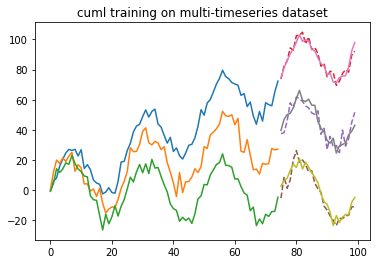

In [148]:
cu_f = cu.forecast(25)
plt.plot(np.arange(0, split), train_df.to_pandas())
plt.plot(np.arange(split, 100), test_df.to_pandas(), linestyle='dashed')
plt.plot(np.arange(split, 100), cu_f.to_pandas())

plt.title("cuml training on multi-timeseries dataset")

In [149]:
r2_score(cu_f[0], test_df['a']), r2_score(cu_f[1], test_df['b']), r2_score(cu_f[2], test_df['c'])

(0.9042691313172587, 0.7946827540902918, 0.8940109775214407)

Text(0.5, 1.0, 'Level Visualization')

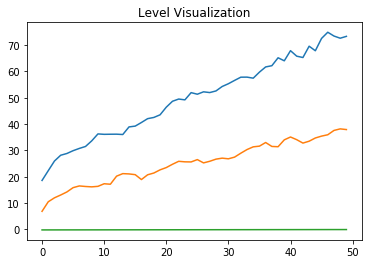

In [150]:
level = cu.get_level().to_array().reshape((3, 50), order='F')
plt.plot(level[0])
plt.plot(level[1])
plt.plot(level[2])
plt.title("Level Visualization")

Text(0.5, 1.0, 'Trend Visualization')

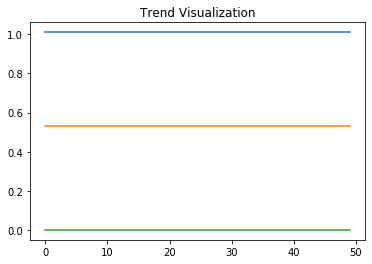

In [151]:
trend = cu.get_trend().to_array().reshape((3, 50), order='F')
plt.plot(trend[0])
plt.plot(trend[1])
plt.plot(trend[2])
plt.title("Trend Visualization")

Text(0.5, 1.0, 'Seasonality Visualization')

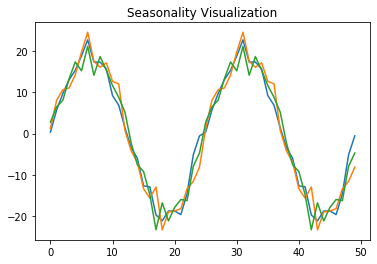

In [152]:
season = cu.get_season().to_array().reshape((3, 50), order='F')
plt.plot(season[0])
plt.plot(season[1])
plt.plot(season[2])
plt.title("Seasonality Visualization")

Text(0, 0.5, 'Number of Passengers')

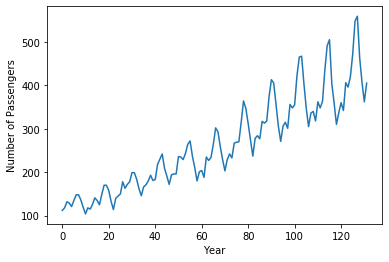

In [134]:
m_trainf = np.array([
  112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126, 141,
  135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 178, 163, 172, 178,
  199, 199, 184, 162, 146, 166, 171, 180, 193, 181, 183, 218, 230, 242, 209,
  191, 172, 194, 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
  204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229, 242, 233, 267,
  269, 270, 315, 364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374,
  413, 405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467, 404,
  347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
  360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405], dtype=np.float64)

m_testf = np.array([417, 391, 419, 461, 472, 535,
                                           622, 606, 508, 461, 390, 432], dtype=np.float64)
plt.plot(m_trainf)
plt.xlabel("Year")
plt.ylabel("Number of Passengers")

In [109]:
cu = cuES(m_trainf, seasonal_periods=12, start_periods=2, ts_num=1, eps=2.24e-7, seasonal='mul')
cu = cu.fit()

sm = smES(m_trainf, seasonal_periods=12, seasonal='mul')
sm = sm.fit()

/home/nfs/dgala/miniconda3/envs/cudf_dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Text(0.5, 1.0, 'cuml vs statsmodels predictions on sine waves')

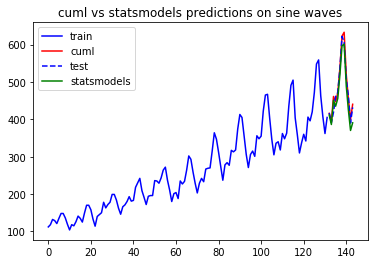

In [110]:
cu_f = cu.forecast(12)
sm_f = sm.forecast(12)
plt.plot(np.arange(0, 132), m_trainf, color='b')
plt.plot(np.arange(132, 144), cu_f.to_pandas(), color='r')
plt.plot(np.arange(132, 144), m_testf, color='b', linestyle='dashed')
plt.plot(np.arange(132, 144), sm_f, color='g')
plt.legend(['train', 'cuml', 'test', 'statsmodels'])
plt.title("cuml vs statsmodels predictions on sine waves")

In [111]:
r2_score(m_testf, cu_f), r2_score(m_testf, sm_f)

(0.9540733671153364, 0.8984355820912462)